# QA Production S/N with ETC expectations [v1.0]

In [7]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import os
from imp import reload

from astropy import units as u
from astropy import constants
from astropy.cosmology import Planck15 as LCDM
from astropy.table import Table

from desispec.qa import qa_prod as dqap
from desispec.qa import qa_plots as dqqp

import specsim.simulator

from desisurvey import etc
import desisurvey

## Load me up

In [3]:
os.environ['DESI_SPECTRO_REDUX'] = '/home/xavier/DESI/DESI_SCRATCH/18.11/spectro/redux'
os.environ['SPECPROD'] = 'mini'

In [4]:
qa_prod = dqap.QA_Prod()
qa_prod.load_data()
qa_prod.load_exposure_s2n()

INFO:qa.py:220:load_qa_multiexp: Loading QA prod file: /home/xavier/DESI/DESI_SCRATCH/18.11/spectro/redux/mini/QA/20200316_qa.json
INFO:qa.py:220:load_qa_multiexp: Loading QA prod file: /home/xavier/DESI/DESI_SCRATCH/18.11/spectro/redux/mini/QA/20200323_qa.json
INFO:qa.py:220:load_qa_multiexp: Loading QA prod file: /home/xavier/DESI/DESI_SCRATCH/18.11/spectro/redux/mini/QA/20200324_qa.json
INFO:qa.py:220:load_qa_multiexp: Loading QA prod file: /home/xavier/DESI/DESI_SCRATCH/18.11/spectro/redux/mini/QA/20200325_qa.json


## Init Simulator

In [68]:
nfiber = 100
desi = specsim.simulator.Simulator('desi', num_fibers=nfiber)

/home/xavier/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/speclite-0.8.dev479-py3.6.egg/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


## ELG profiles (from desimodel/doc/nb/ELG_SNR.ipynb)
    Used for the fiducial S/N value

In [61]:
def generate_elg_profiles(z, seed=123, verbose=False):
    """ELG profiles are assumed to be disk (Sersic n=1) only.
    """
    gen = np.random.RandomState(seed)
    nsrc = len(z)
    source_fraction = np.zeros((nsrc, 2))
    source_half_light_radius = np.zeros((nsrc, 2))
    source_minor_major_axis_ratio = np.zeros((nsrc, 2))
    source_position_angle = 360. * gen.normal(size=(nsrc, 2))
    # Precompute cosmology scale factors.
    angscale = (
        LCDM.angular_diameter_distance(1.0) /
        LCDM.angular_diameter_distance(z)).to(1).value
    if verbose:
        print(f'mean n(z) DA(1.0)/DA(z) = {np.mean(angscale):.3f}')
    # Disk only with random size and ellipticity.
    source_fraction[:, 0] = 1.
    source_half_light_radius[:, 0] = 0.427 * np.exp(0.25 * gen.normal(size=nsrc)) * angscale
    source_minor_major_axis_ratio[:, 0] = np.minimum(0.99, 0.50 * np.exp(0.15 * gen.normal(size=nsrc)))
    if verbose:
        print(f'mean HLR = {np.mean(source_half_light_radius[:, 0]):.3f}"')
    return dict(
        source_fraction=source_fraction,
        source_half_light_radius=source_half_light_radius,
        source_minor_major_axis_ratio=source_minor_major_axis_ratio,
        source_position_angle=source_position_angle)

## Load meta

In [5]:
meta = Table.read('/home/xavier/DESI/DESI_SCRATCH/18.11/survey/exposures.fits')
meta

EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,deg,deg,,,,s,arcsec,,,,deg,deg,,
int32,int32,int16,float64,float64,float32,bytes8,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes7
0,-1,-1,0.0,0.0,0.0,20200316,58925.10389689015,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
1,-1,-1,0.0,0.0,0.0,20200316,58925.10435985311,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
2,-1,-1,0.0,0.0,0.0,20200316,58925.10482281607,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
3,-1,-1,0.0,0.0,0.0,20200316,58925.10528577904,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
4,-1,-1,0.0,0.0,0.0,20200316,58925.105748742004,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
5,-1,-1,0.0,0.0,0.0,20200316,58925.106211704966,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
6,34170,5,151.82,30.5,0.021682816,20200316,58925.10667466793,327.4658062613244,0.799289882183075,0.9207070469856262,1.359901419566095,0.40834738029550954,-80.2817949877562,130.3220397265792,BRIGHT,science
7,1165,0,150.69,33.86,0.012653735,20200316,58925.11311485859,722.8547808959272,0.7572662830352783,0.7192993760108948,1.288850214050581,0.40834738029550954,-79.23115858223505,131.63996122192202,DARK,science


## Plot time

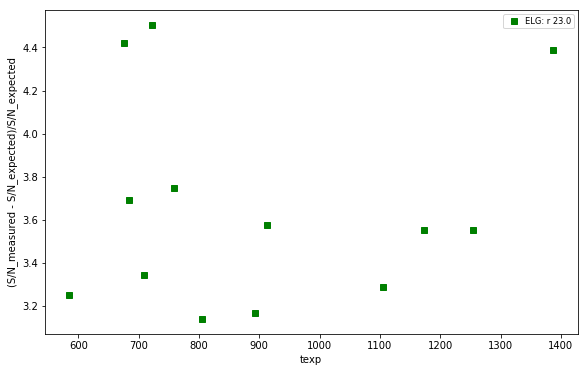

In [31]:
reload(dqqp)
dqqp.prod_delta_s2n(qa_prod, meta, xaxis='texp')

----

## TESTING

In [38]:
desi.source.wavelength_out

<Quantity [3550. , 3550.1, 3550.2, ..., 9849.8, 9849.9, 9850. ] Angstrom>

In [40]:
desi.simulated['wavelength'][-1]

9850.0

In [46]:
# Fiducial r-band wavelengths with padding for specsim
wlen = np.array([3549.]+(6600. + np.arange(300)).tolist() + [9855.]) * u.Angstrom

In [82]:
z_ELG = 1.

In [83]:
# Flux
mR = 23. # AB R-band
fnu = 10**(-1*(mR + 48.6)/2.5) * u.erg/u.s/u.cm**2/u.Hz
# 
flamb = (fnu * constants.c / np.median(wlen)**2).to('erg/s/cm**2/Angstrom')
flux = np.ones_like(wlen.value) * flamb

In [84]:
desi.source.update_in('ELG [OII] doublet', 'elg', wlen, flux, z_in=0.)

In [85]:
desi.source.update_out()#z_out=0.)

In [86]:
sources = generate_elg_profiles(np.ones(nfiber)*z_ELG)

In [87]:
desi.simulate(**sources)#source_fluxes=source_flux)

In [88]:
z=0.
lo, hi = 6605., 6650.
for icamera, output in enumerate(desi.camera_output):
    rest_wlen = output['wavelength'] / (1 + z)
    # Loop over emission lines.
    sel = (rest_wlen >= lo) & (rest_wlen < hi)
    if not np.any(sel):
        continue
    # Sum SNR2 over pixels.
    pixel_snr2 = output['num_source_electrons'][sel] ** 2 / output['variance_electrons'][sel]
    #import pdb; pdb.set_trace()
    print(icamera, np.median(pixel_snr2))

1 0.08471365025084916


In [50]:
len(desi.camera_output)

3

In [57]:
desi.instrument.fiberloss_method 

'fastsim'

In [58]:
desi.observation.exposure_time

<Quantity 1000. s>

In [89]:
desi.atmosphere.seeing_fwhm_ref

<Quantity 1.1 arcsec>

## Observing meta

In [12]:
row = meta[32]
row

EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,deg,deg,,,,s,arcsec,,,,deg,deg,,
int32,int32,int16,float64,float64,float32,bytes8,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes7
32,16870,2,151.96000000000004,31.21,0.02075856,20200324,58933.132231053656,708.1042326110194,1.100396990776062,0.970128059387207,1.1392055865516846,0.00905324863754342,-12.7429369806801,130.04276047992806,DARK,science


In [8]:
config = desisurvey.config.Configuration()

In [14]:
program = row['PROGRAM']
nominal_time = getattr(config.nominal_exposure_time, program)()
nominal_time

<Quantity 1000. s>

In [16]:
f_seeing = etc.seeing_exposure_factor(row['SEEING'])
f_seeing

1.0005349521717815

In [21]:
f_transparency = etc.transparency_exposure_factor(row['TRANSPARENCY'])
f_dust = etc.dust_exposure_factor(row['EBMV'])
f_airmass = etc.airmass_exposure_factor(row['AIRMASS'])
f_moon = etc.moon_exposure_factor(row['MOONFRAC'], row['MOONSEP'], row['MOONALT'], row['AIRMASS'])
f_transparency, f_dust, f_airmass, f_moon

(1.0307917499383144, 1.1346251836599501, 1.176935418261061, 1.0)

In [22]:
nominal_time * f_seeing * f_transparency * f_dust * f_airmass * f_moon 

<Quantity 1377.23563081 s>

----

## Questions
    What size is sensible? (e.g. what median redshift for r=23 mag?)
    How is seeing being handled